In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import pearsonr


# 1. Setup

## Data loading and definitions

In [2]:
# Load the data
df = pd.read_csv('data/Sample.csv')

# List of object columns
object_cols = [
    'cushions',
    'mortar',
    'dough_trough',
    'candelabrum',
    'green_dyestuff',
    'ruby_red_dyestuff',
    'spit',
    'lamp',
    'silk',
    'black_dyestuff',
    'gold',
    'purple_dyestuff',
    'sendal',
    'amber',
    'yellow_dyestuff',
    'alexandria',
    'alembic',
    'damascus',
    'pulvinar',
    'coysin',
    'auricula',
    'fluna',
    'transverser',
]

date_groupings = {
    '1250-1299': range(1250, 1300),
    '1300-1349': range(1300, 1350),
    '1350-1399': range(1350, 1400),
    '1400-1449': range(1400, 1450),
}


## Data manipulation

In [3]:
# add unique id
df['id'] = df.index

# Replace NaN values in object_cols with 0 and convert to integers
df[object_cols] = df[object_cols].fillna(0).astype(int)

# Ensure object_phrases is numeric
df['object_phrases'] = pd.to_numeric(df['object_phrases'], errors='coerce')

# ensure all object_cols are numeric
for col in object_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Melt to long format
df_long = df.melt(
    id_vars=['id', 'date_group', 'date_group_no', 'object_phrases'],
    value_vars=object_cols,
    var_name='object_type',
    value_name='present',
)
df_long['present'] = pd.to_numeric(df_long['present'], errors='coerce').fillna(0).astype(int)

# Convert 'present' to numeric (in case of missing/blank values)
df_long['present'] = pd.to_numeric(df_long['present'], errors='coerce').fillna(0).astype(int)

# Group by date_group and object_type
dategroup = df_long.groupby(['date_group', 'object_type'])['present'].sum().unstack(fill_value=0)


# 2. Exploration

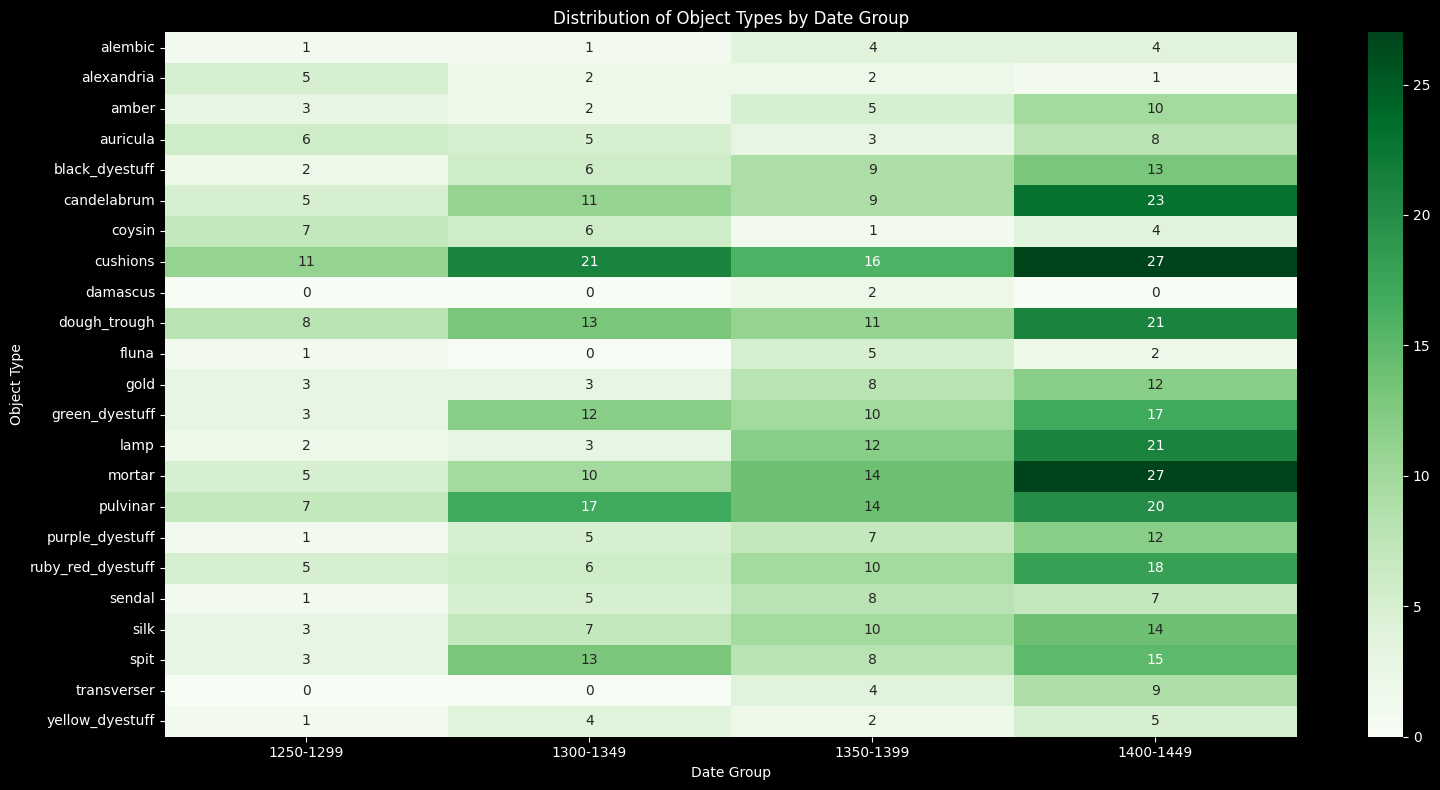

In [4]:
# Plot heatmap for date_group vs object_type
plt.figure(figsize=(16, 8))
sns.heatmap(dategroup.T, cmap='Greens', annot=True, fmt='d')
plt.title('Distribution of Object Types by Date Group')
plt.xlabel('Date Group')
plt.ylabel('Object Type')
plt.tight_layout()
plt.show()

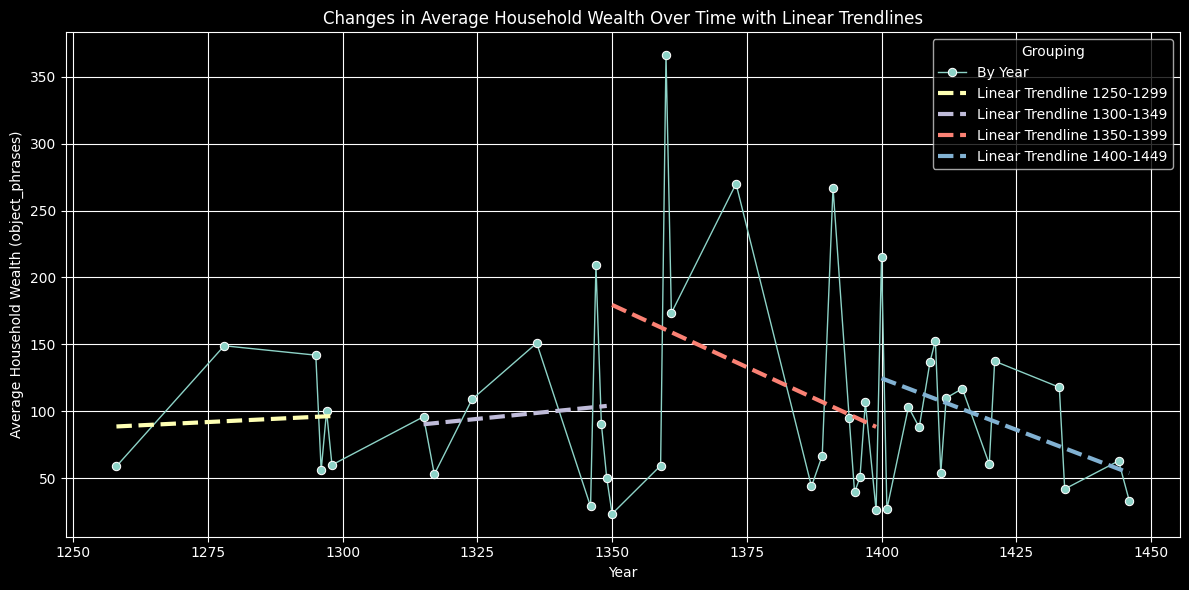

In [5]:
# Calculate average household wealth by year
average_wealth_by_year = df.groupby('year')['object_phrases'].mean().reset_index()

# Add interval trendlines to the chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=average_wealth_by_year, x='year', y='object_phrases', marker='o', label='By Year', linewidth=1)


# Add linear trendlines for each interval
def add_linear_trendlines(ax, date_groupings, df):
    """Add linear trendlines for each date grouping."""
    for group, year_range in date_groupings.items():
        interval_data = df[df['year'].isin(year_range)].groupby('year')['object_phrases'].mean().reset_index()
        if not interval_data.empty:
            # Fit a linear trendline
            p = Polynomial.fit(interval_data['year'], interval_data['object_phrases'], 1)
            trendline = p(interval_data['year'])
            ax.plot(interval_data['year'], trendline, linestyle='--', linewidth=3, label=f'Linear Trendline {group}')


ax = plt.gca()
add_linear_trendlines(ax, date_groupings, df)

plt.title('Changes in Average Household Wealth Over Time with Linear Trendlines')
plt.xlabel('Year')
plt.ylabel('Average Household Wealth (object_phrases)')
plt.legend(title='Grouping')
plt.grid(True)
plt.tight_layout()
plt.show()

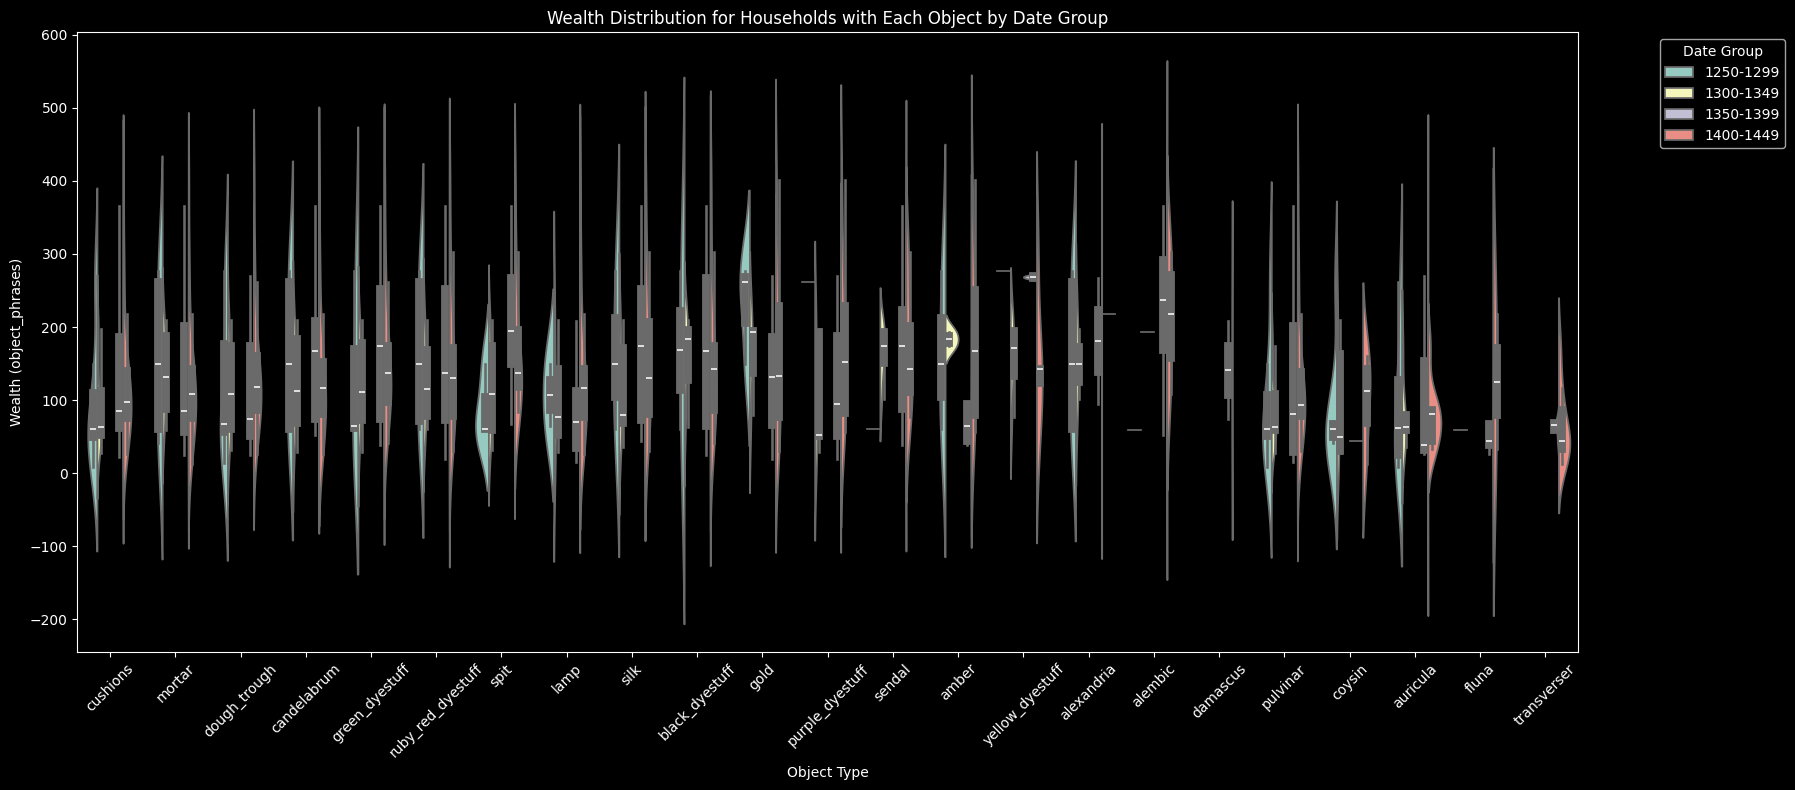

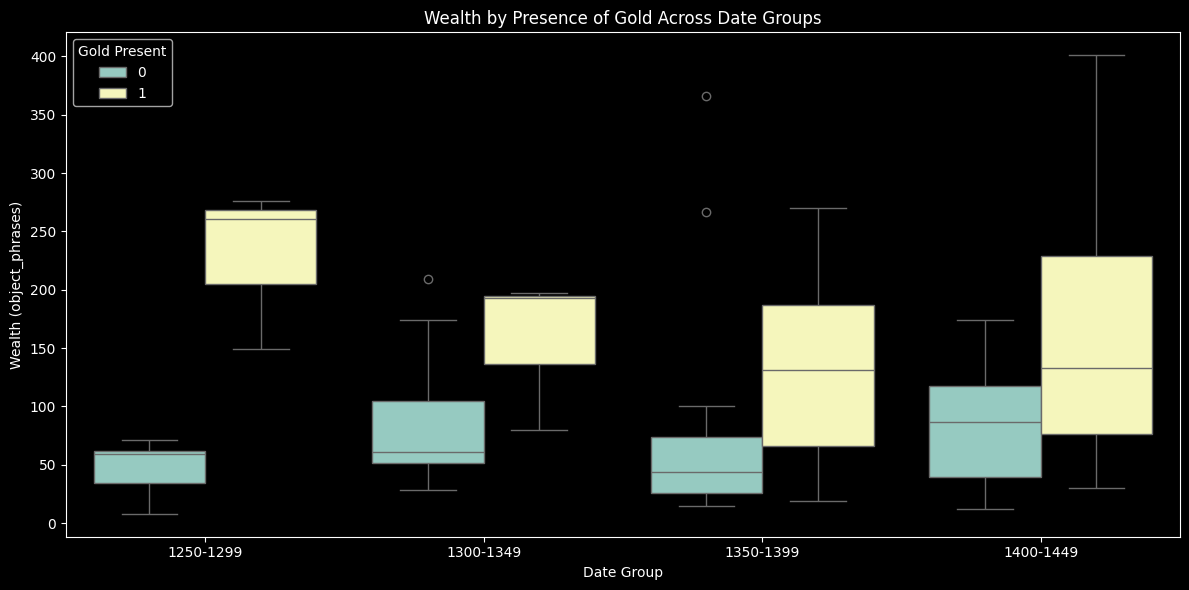

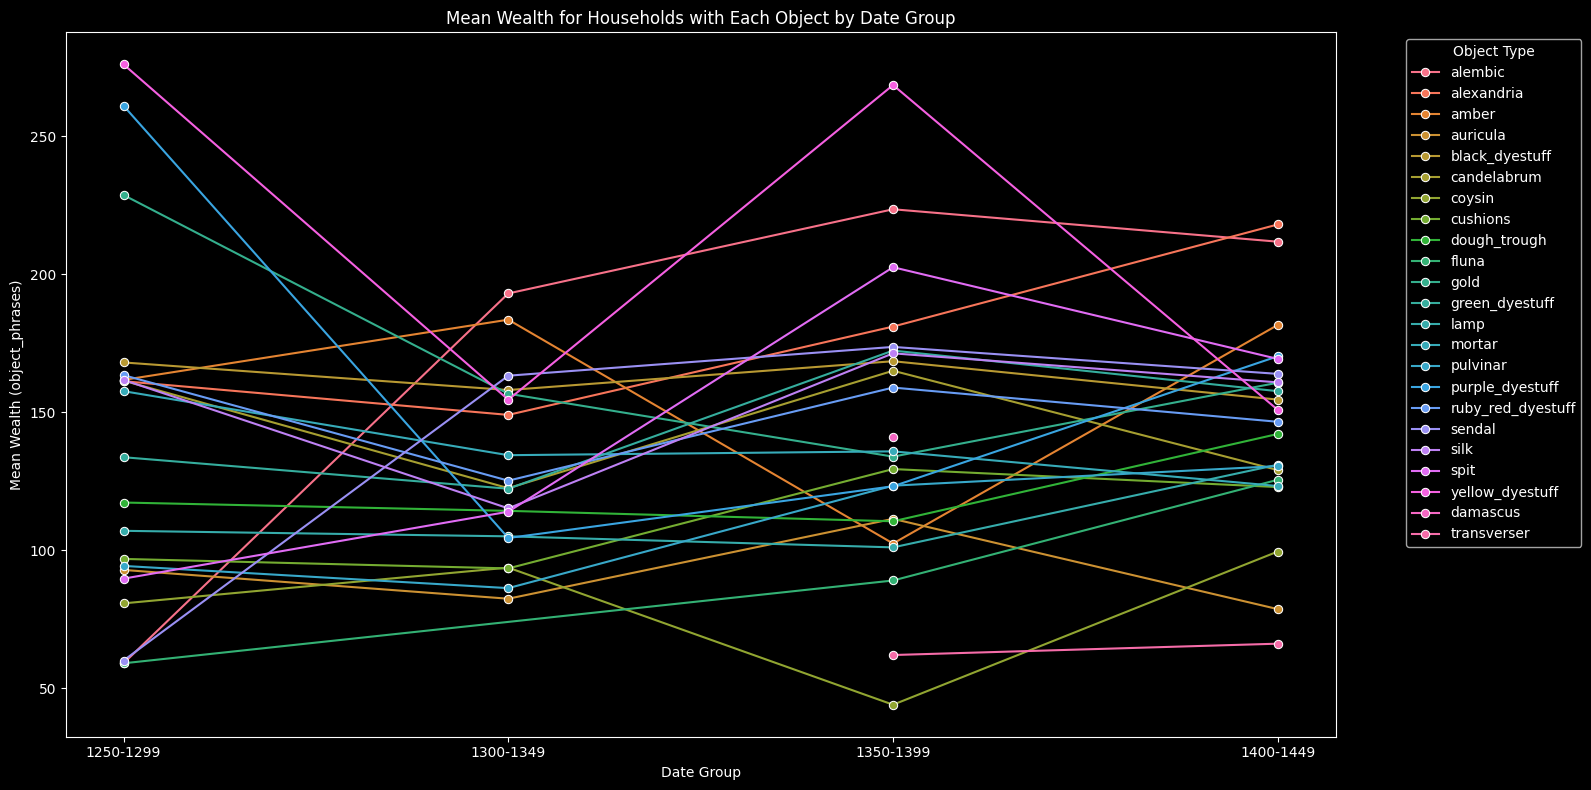

In [6]:
# Violin plot: Wealth distribution for households with each object, grouped by date_group
plt.figure(figsize=(18, 8))
sns.violinplot(data=df_long[df_long['present'] == 1], x='object_type', y='object_phrases', hue='date_group', split=True)
plt.title('Wealth Distribution for Households with Each Object by Date Group')
plt.xlabel('Object Type')
plt.ylabel('Wealth (object_phrases)')
plt.xticks(rotation=45)
plt.legend(title='Date Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Boxplot: Wealth by object presence (1/0), for a single object type, grouped by date_group
object_to_plot = 'gold'  # Change to any object type you want
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long[df_long['object_type'] == object_to_plot], x='date_group', y='object_phrases', hue='present')
plt.title(f'Wealth by Presence of {object_to_plot.capitalize()} Across Date Groups')
plt.xlabel('Date Group')
plt.ylabel('Wealth (object_phrases)')
plt.legend(title=f'{object_to_plot.capitalize()} Present')
plt.tight_layout()
plt.show()

# Lineplot: Mean wealth for households with each object, by date_group
mean_wealth = (
    df_long[df_long['present'] == 1].groupby(['date_group', 'object_type'])['object_phrases'].mean().reset_index()
)
plt.figure(figsize=(16, 8))
sns.lineplot(data=mean_wealth, x='date_group', y='object_phrases', hue='object_type', marker='o')
plt.title('Mean Wealth for Households with Each Object by Date Group')
plt.xlabel('Date Group')
plt.ylabel('Mean Wealth (object_phrases)')
plt.legend(title='Object Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Analysis

## Does the presence of certain objects correlate with the wealth of a household?

We can calculate the Pearson correlation between the presence/absence of different objects and the wealth of a household. We use the size of the inventory, *i.e.* the total number of objects—measured in `object_phrases`—as a proxy for the latter.

The **correlation coefficients** measure the strength and direction of the relationship between the presence of an object type and household wealth. Values close to `+1` indicate a strong positive correlation, meaning households with the object tend to be wealthier, values close to `-1` indicate a strong negative correlation, meaning households with the object tend to be less wealthy, while values near `0` suggest no significant relationship.

The **p-values** indicate the statistical significance of the correlation: less than `0.05` typically suggests the correlation is statistically significant, while higher p-values indicate weaker evidence against the null hypothesis (*i.e.* no correlation).

In [7]:
# Calculate correlation coefficients and p-values
correlation_results = []
for col in object_cols:
    corr, p_value = pearsonr(df[col], df['object_phrases'])
    correlation_results.append({'object_type': col, 'correlation': corr, 'p_value': p_value})

# Convert results to DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Display correlation results
display(correlation_df)

,object_type,correlation,p_value
0,cushions,0.300831,4.885703e-03
1,mortar,0.475316,3.754316e-06
2,dough_trough,0.341572,1.287957e-03
3,candelabrum,0.475158,3.786102e-06
4,green_dyestuff,0.550727,3.931574e-08
5,ruby_red_dyestuff,0.505534,6.883925e-07
6,spit,0.537993,9.192077e-08
7,lamp,0.167138,1.240161e-01
8,silk,0.507327,6.192321e-07
9,black_dyestuff,0.509996,5.283903e-07


### Visualize correlation results

The heatmap visually represents the correlation coefficients for each object type. Darker colors (*e.g.*, red or blue) indicate stronger correlations, while lighter colors suggest weaker or no correlation.

The lineplot shows trends in correlation coefficients across object types. Peaks or dips in the plot highlight object types with particularly strong positive or negative correlations.

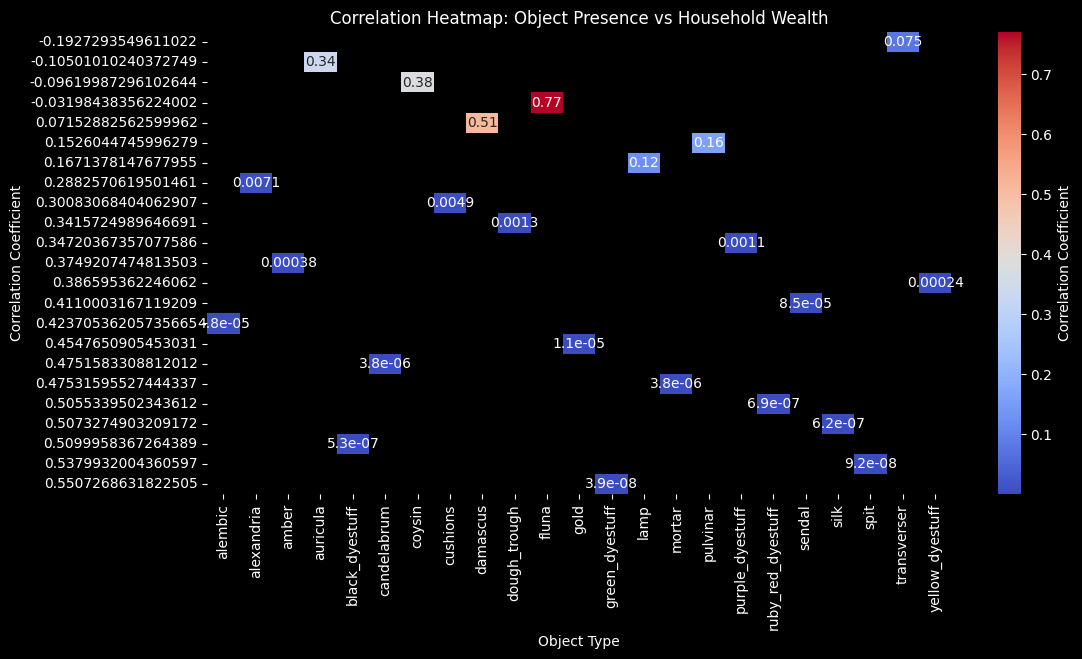

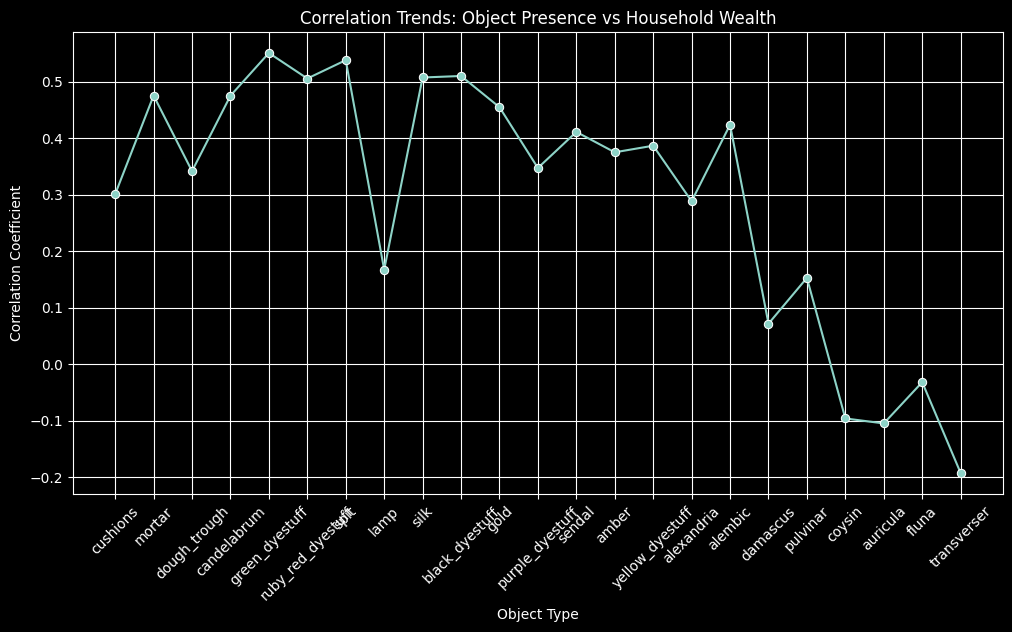

In [8]:
# Visualize correlation results
plt.figure(figsize=(12, 6))
sns.heatmap(
    correlation_df.pivot(index='correlation', columns='object_type', values='p_value'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'},
)
plt.title('Correlation Heatmap: Object Presence vs Household Wealth')
plt.xlabel('Object Type')
plt.ylabel('Correlation Coefficient')
plt.show()

# Lineplot for correlations
plt.figure(figsize=(12, 6))
sns.lineplot(data=correlation_df, x='object_type', y='correlation', marker='o')
plt.title('Correlation Trends: Object Presence vs Household Wealth')
plt.xlabel('Object Type')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.grid(True)  # noqa: FBT003
plt.show()

### Interpretation

The strongest associations are observed for dyestuffs (*e.g.*, green, ruby red, black), silk, and spits, which based on these results are statistically significant indicators of household wealth. Cushions and pillows show no significant correlation.

**Strongest positive associations with household wealth:**

- Green dyestuff (correlation = 0.550727, p_value = 3.93e-08)
- Spits (correlation = 0.537993, p_value = 9.19e-08)
- Ruby-red dyestuff (correlation = 0.505534, p_value = 6.88e-07)
- Silk (correlation = 0.507327, p_value = 6.19e-07)
- Black dyestuff (correlation = 0.509996, p_value = 5.28e-07)

These object types have the highest positive correlation coefficients and statistically significant p-values (less than 0.05), indicating strong and significant relationships with household wealth.

**Weak or No Significant Associations:**

- Objects associated with Damascus (correlation = 0.071529, p_value = 0.512813)
- Cushions and pillows:
    - *pulvinar* (correlation = 0.152604, p_value = 0.160701)
    - *coysin-* (correlation = -0.096200, p_value = 0.378257)
    - *auricula-* (correlation = -0.105010, p_value = 0.335930)
    - *fluna* (correlation = -0.031984, p_value = 0.770022)
    - *transverser-* (correlation = -0.192729, p_value = 0.075428)

These object types have low correlation coefficients and high p-values, suggesting weak or no significant relationships with household wealth.

### Do these results hold for all date groups?

We can re-run the analysis for each time interval:


In [ ]:
# Calculate correlation coefficients and p-values for each time interval
def calculate_interval_correlations(df, object_cols, date_groupings):
    """Calculate correlation coefficients and p-values for each object type within specified date groupings."""
    results = []
    for group, year_range in date_groupings.items():
        interval_data = df[df['year'].isin(year_range)]
        for col in object_cols:
            if not interval_data.empty:
                corr, p_value = pearsonr(interval_data[col], interval_data['object_phrases'])
                results.append({'date_group': group, 'object_type': col, 'correlation': corr, 'p_value': p_value})
    return pd.DataFrame(results)


# Perform analysis
interval_correlation_df = calculate_interval_correlations(df, object_cols, date_groupings)

# Display correlation results
display(interval_correlation_df)

/var/folders/yd/542gy2_d73j4cmb98j3192th0000gp/T/ipykernel_9989/3929264277.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(interval_data[col], interval_data['object_phrases'])


,date_group,object_type,correlation,p_value
0,1250-1299,cushions,NaN,NaN
1,1250-1299,mortar,0.629740,0.037856
2,1250-1299,dough_trough,0.378678,0.250792
3,1250-1299,candelabrum,0.669111,0.024351
4,1250-1299,green_dyestuff,0.256102,0.447173
...,...,...,...,...
87,1400-1449,pulvinar,0.287717,0.110312
88,1400-1449,coysin,-0.054485,0.767099
89,1400-1449,auricula,-0.226148,0.213284
90,1400-1449,fluna,0.042387,0.817826


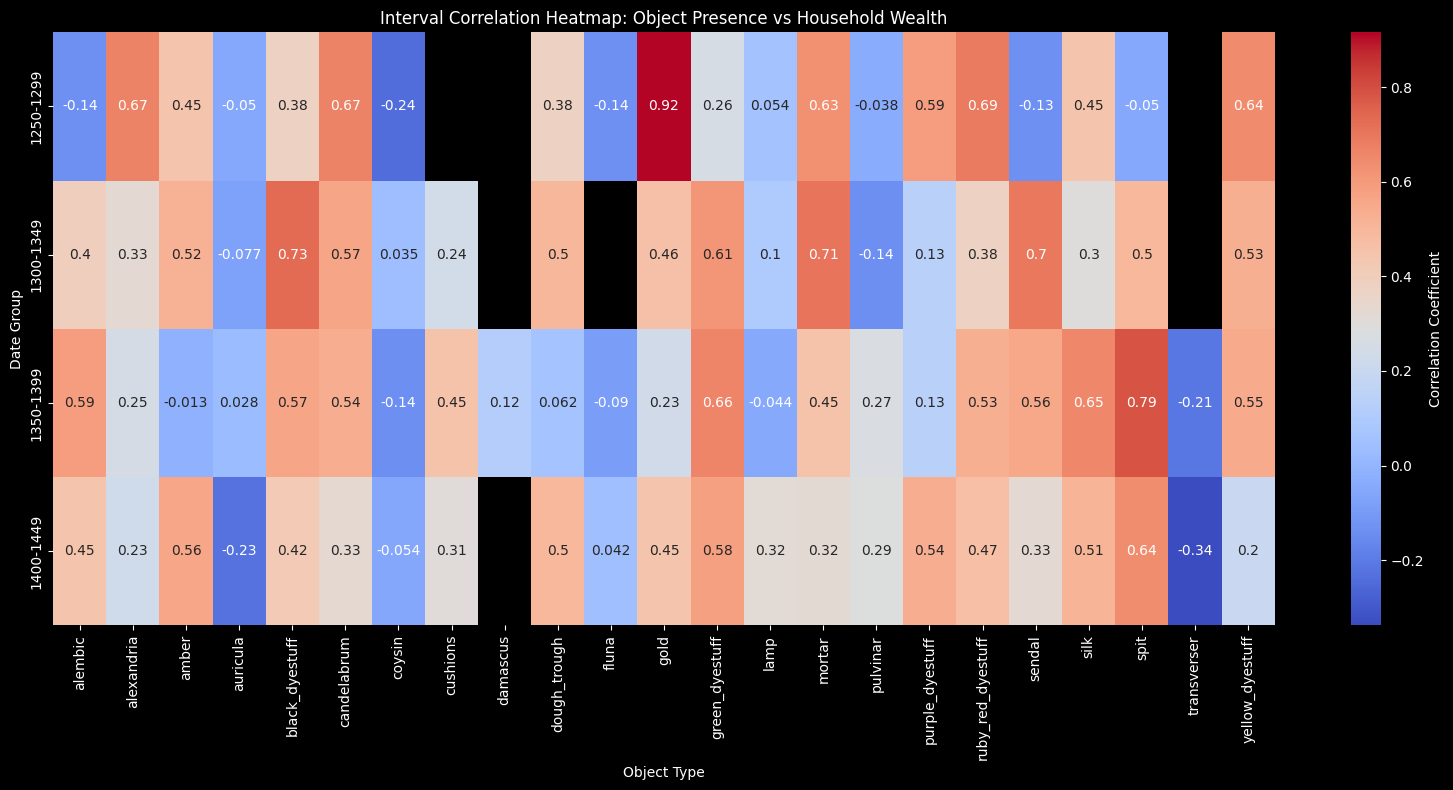

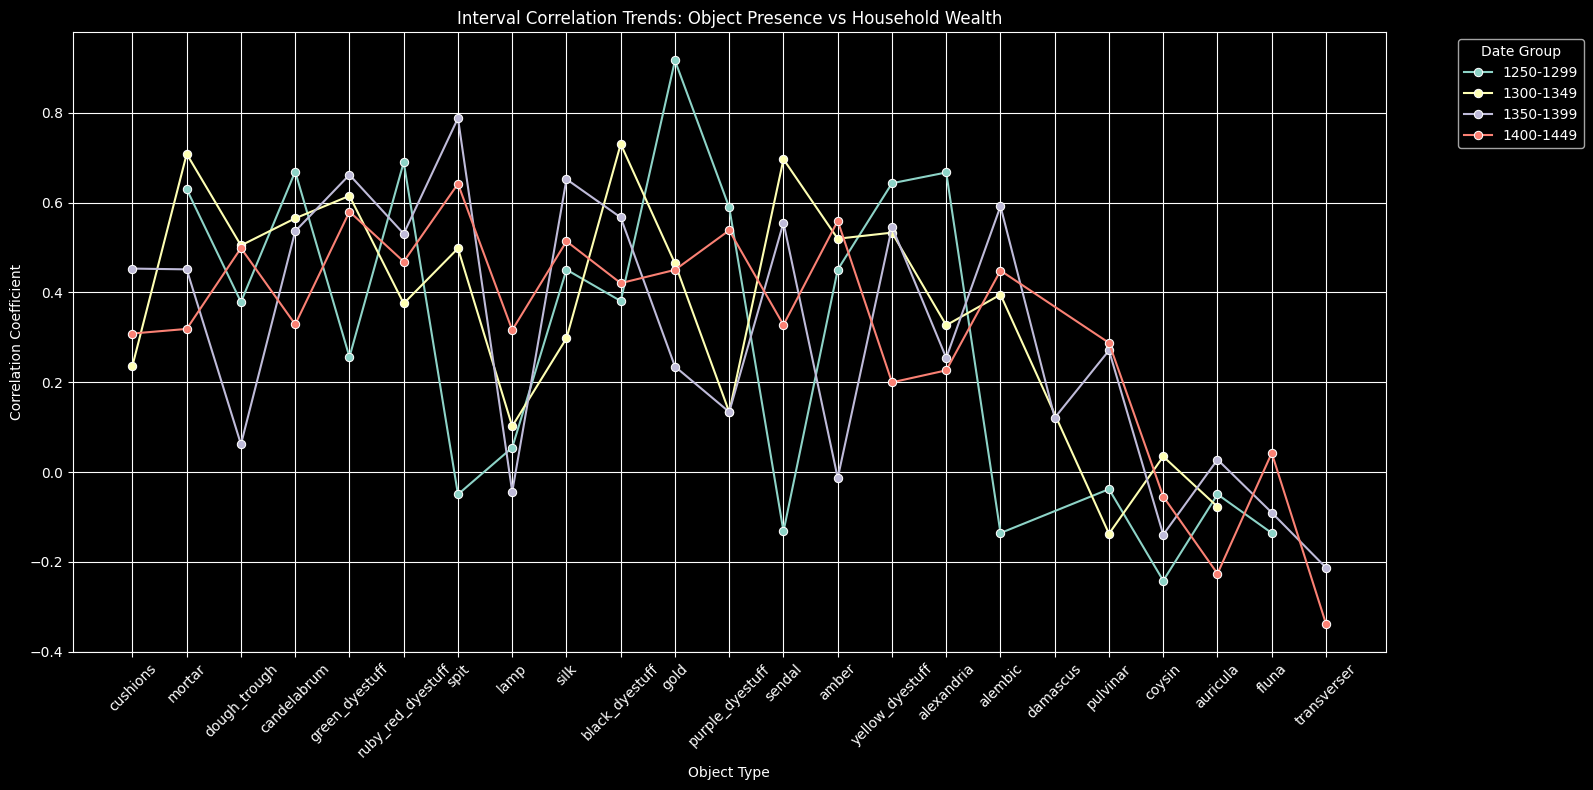

In [16]:
# Visualize interval correlation results
plt.figure(figsize=(16, 8))
sns.heatmap(
    interval_correlation_df.pivot(index='date_group', columns='object_type', values='correlation'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'},
)
plt.title('Interval Correlation Heatmap: Object Presence vs Household Wealth')
plt.xlabel('Object Type')
plt.ylabel('Date Group')
plt.tight_layout()
plt.show()

# Lineplot for interval correlations
plt.figure(figsize=(16, 8))
sns.lineplot(data=interval_correlation_df, x='object_type', y='correlation', hue='date_group', marker='o')
plt.title('Interval Correlation Trends: Object Presence vs Household Wealth')
plt.xlabel('Object Type')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.legend(title='Date Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)  # noqa: FBT003
plt.tight_layout()
plt.show()

### Interpretation

Gold in decorative item or jewelry, spits, green dyestuff, and silk consistently show strong positive correlations with wealth across multiple time intervals. Cushions and pillows generally show weak or no significant correlations with wealth.

**Key Findings by Time Interval:**
- 1250-1299: Gold in decorative item or jewelry shows the strongest positive correlation (correlation = 0.916, p-value = 0.000073), indicating a significant association with wealth. Ruby-red dyestuff (correlation = 0.690, p-value = 0.0188) and candelabrum (correlation = 0.669, p-value = 0.0244) also show strong positive correlations. Spits and lamps have weak or no significant correlations (p-values > 0.05).

- 1300-1349: Black dyestuff (correlation = 0.730, p-value = 0.000114) and mortars (correlation = 0.708, p-value = 0.000225) are highly correlated with wealth. Sendal (correlation = 0.696, p-value = 0.000316) and green dyestuff (correlation = 0.615, p-value = 0.0023) also show strong positive correlations. Cushions and pillows have weak or no significant correlations (p-values > 0.05).

- 1350-1399: Spits (correlation = 0.788, p-value = 0.000022) and green dyestuff (correlation = 0.662, p-value = 0.0011) are strongly associated with wealth. Silk (correlation = 0.652, p-value = 0.0014) and black dyestuff (correlation = 0.567, p-value = 0.0074) also show significant positive correlations. Amber, as well as cushions and pillows have weak or no significant correlations (p-values > 0.05).

- 1400-1449: Spits (correlation = 0.642, p-value = 0.000075) and green dyestuff (correlation = 0.580, p-value = 0.000505) remain strong indicators of wealth. Silk (correlation = 0.514, p-value = 0.0026) and amber (correlation = 0.559, p-value = 0.000878) also show significant positive correlations.Cushions and pillows have weak or no significant correlations (p-values > 0.05).
